In [1]:
%matplotlib notebook

from math import sqrt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pvlib

from sistemas import genera_pot_pv, genera_pot_cpv, genera_pot_static_cpv, genera_pot_flatplate

# Parámetros entrada

In [2]:
# lat, lon = 40.4, -3.7 # Madrid
# lat, lon = 36.857, -2.481 # Almeria
# lat, lon = 43.362, -5.850 # Oviedo
# lat, lon = 0.912, -77.100 # Ecuador (zona muy cubierta)
lat, lon = 55.974, -3.179 # Edinburgh
# lat, lon = 46.527, 6.605 # Laussane
# lat, lon = 23.998, 3.784 # Tamanraset

tilt = lat - 10

eff_opt_cpv = 0.83
eff_opt_pv = 0.70

spillage_factor = 0.02

diffuse_model = 'haydavies'

in_tracker = False

# Lectura TMY(PVGIS) y Análisis irradiancia

poa_global     881.502832
poa_diffuse    529.887944
dtype: float64


<IPython.core.display.Javascript object>


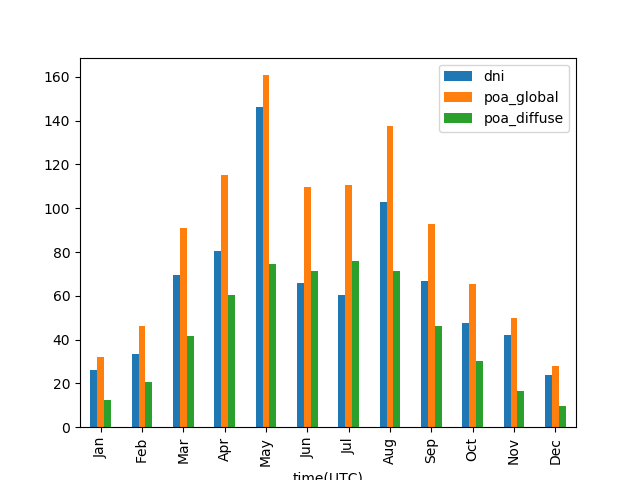

dni             764.699050
poa_global     1039.055574
poa_diffuse     530.936031
dtype: float64


In [13]:
data_pvgis = pvlib.iotools.get_pvgis_tmy(lat, lon)

alt = data_pvgis[2]['location']['elevation']

data_tmy = data_pvgis[0].rename(columns={
    'Gb(n)': 'dni',
    'G(h)': 'ghi',
    'Gd(h)': 'dhi',
    'T2m': 'temp_air',
    'WS10m': 'wind_speed',
})

data = data_tmy.set_index(
    data_tmy.index.map(lambda t: t.replace(year=2010)))

location = pvlib.location.Location(
    latitude=lat, longitude=lon, altitude=alt, tz='utc')

solpos = location.get_solarposition(data.index)

data[['poa_global', 'poa_diffuse']] = pvlib.irradiance.get_total_irradiance(surface_tilt=tilt, surface_azimuth=180,
                         solar_zenith=solpos['zenith'], solar_azimuth=solpos['azimuth'],
                         dni=data['dni'], ghi=data['ghi'], dhi=data['dhi'],
                         dni_extra=pvlib.irradiance.get_extra_radiation(data.index), model=diffuse_model,
                        )[['poa_global', 'poa_diffuse']]

data_monthly = data[['dni', 'poa_global', 'poa_diffuse']].resample('M').sum() / 1000

ax = data_monthly.plot(kind='bar')
ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(data_monthly.sum())

# Sistema PV (plano fijo)

In [4]:
pv_irradiance, pv_p_mp, pv_p_mp_25, pv_Pdc_stc, pv_eff_a = genera_pot_pv(location, solpos, data, 
                                                    tilt, diffuse_model, in_singleaxis_tracker=in_tracker)

Yr = pv_irradiance.resample('M').sum() / 1000
Ya = pv_p_mp.resample('M').sum() / pv_Pdc_stc
Ya_25 = pv_p_mp_25.resample('M').sum() / pv_Pdc_stc

Lc = Yr - Ya
Lt = Ya_25 - Ya

PR = Ya / Yr

data_monthly = pd.concat([Yr, PR], axis='columns')
data_monthly.columns = ['Yr', 'PR']

# ax = data_monthly.plot(kind='bar', secondary_y='PR')
# ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(f'\nTilt={tilt:.1f} in_tracker={in_tracker}')
print(f'pv_Pdc_stc={pv_Pdc_stc:.0f} pv_eff_a={pv_eff_a:.2%}')
print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW')
print(f'Lt={Lt.sum():.0f} kWh/kW')
print(f'Total annual energy per reference area={pv_p_mp.sum()/1000:.0f} kWh/year')


Tilt=46.0 in_tracker=False
pv_Pdc_stc=2050 pv_eff_a=20.50%
PR=0.94, Ya=975 kWh/kW, Yr=1039 kWh/kW
Lt=7 kWh/kW
Total annual energy per reference area=1999 kWh/year


# Sistema CPV (2 ejes)

In [5]:
cpv_irradiance, cpv_p_mp, cpv_p_mp_25, cpv_Pdc_stc, cpv_eff_a = genera_pot_cpv(location, solpos, data, tilt, eff_opt_cpv)

Yr = cpv_irradiance.resample('M').sum() / 1000
Ya = cpv_p_mp.resample('M').sum() / cpv_Pdc_stc
Ya_25 = cpv_p_mp_25.resample('M').sum() / cpv_Pdc_stc

Lc = Yr - Ya
Lt = Ya_25 - Ya

PR = Ya / Yr

data_monthly = pd.concat([Yr, PR], axis='columns')
data_monthly.columns = ['Yr', 'PR']

# ax = data_monthly.plot(kind='bar', secondary_y='PR')
# ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(f'cpv_Pdc_stc={cpv_Pdc_stc:.0f} cpv_eff_a={cpv_eff_a:.2%}')
print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW')
print(f'Lt={Lt.sum():.0f} kWh/kW')
print(f'Total annual energy per reference area={cpv_p_mp.sum()/1000:.0f} kWh/year')

C:\Users\Ruben\Documents\GitHub\StaticHybridSystem-benchmark\cpvlib.py:206: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)


cpv_Pdc_stc=3487 cpv_eff_a=34.87%
PR=0.81, Ya=621 kWh/kW, Yr=765 kWh/kW
Lt=2 kWh/kW
Total annual energy per reference area=2167 kWh/year


# Sistema StaticCPV (plano fijo)

In [6]:
# for tilt in range(30, 40, 1):
cpv_static_irradiance, cpv_static_p_mp, cpv_static_p_mp_25, cpv_static_Pdc_stc, cpv_static_eff_a = genera_pot_static_cpv(location, solpos, data, tilt, 
                                                                                    eff_opt_cpv, in_singleaxis_tracker=in_tracker)

Yr = cpv_static_irradiance.resample('M').sum() / 1000
Ya = cpv_static_p_mp.resample('M').sum() / cpv_static_Pdc_stc
Ya_25 = cpv_static_p_mp_25.resample('M').sum() / cpv_static_Pdc_stc

Lc = Yr - Ya
Lt = Ya_25 - Ya

PR = Ya / Yr

data_monthly = pd.concat([Yr, PR], axis='columns')
data_monthly.columns = ['Yr', 'PR']

# ax = data_monthly.plot(kind='bar', secondary_y='PR')
# ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(f'\nTilt={tilt:.1f} in_tracker={in_tracker}')
print(f'cpv_static_Pdc_stc={cpv_static_Pdc_stc:.0f} cpv_static_eff_a={cpv_static_eff_a:.2%}')
print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW')
print(f'Lt={Lt.sum():.0f} kWh/kW')
print(f'Total annual energy per reference area={cpv_static_p_mp.sum()/1000:.0f} kWh/year')


Tilt=46.0 in_tracker=False
cpv_static_Pdc_stc=3487 cpv_static_eff_a=34.87%
PR=0.69, Ya=350 kWh/kW, Yr=508 kWh/kW
Lt=76 kWh/kW
Total annual energy per reference area=1222 kWh/year


# Sistema FlatplatePV-Difusa(plano fijo, difusa+dni(aoi_limit)+spillage)
Solo entrada=difusa -> aoi_limit=90

In [7]:
# for tilt in range(30, 40, 1):
type_irr_input = 'diffuse'
aoi_limit = 90

cpv_irradiance_spillage = cpv_static_irradiance * spillage_factor

pv_diffuse_irradiance, pv_diffuse_p_mp, pv_diffuse_p_mp_25, pv_diffuse_Pdc_stc, pv_diffuse_eff_a = genera_pot_flatplate(location, solpos, data, diffuse_model, tilt, 
                                                                        aoi_limit, eff_opt_pv, cpv_irradiance_spillage, 
                                                                        type_irr_input, in_singleaxis_tracker=in_tracker)

Yr = pv_diffuse_irradiance.resample('M').sum() / 1000
Ya = pv_diffuse_p_mp.resample('M').sum() / pv_diffuse_Pdc_stc
Ya_25 = pv_diffuse_p_mp_25.resample('M').sum() / pv_diffuse_Pdc_stc

Lc = Yr - Ya
Lt = Ya_25 - Ya

PR = Ya / Yr

data_monthly = pd.concat([Yr, PR], axis='columns')
data_monthly.columns = ['Yr', 'PR']

# ax = data_monthly.plot(kind='bar', secondary_y='PR')
# ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(f'\nTilt={tilt:.1f} in_tracker={in_tracker}')
print(f'pv_diffuse_Pdc_stc={pv_diffuse_Pdc_stc:.0f} pv_diffuse_eff_a={pv_diffuse_eff_a:.2%}')
print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW')
print(f'Lt={Lt.sum():.0f} kWh/kW')
print(f'Total annual energy per reference area={pv_diffuse_p_mp.sum()/1000:.0f} kWh/year')

C:\Users\Ruben\Documents\GitHub\StaticHybridSystem-benchmark\cpvlib.py:713: pvlibDeprecationWarning: The pvsyst_celltemp function was deprecated in pvlib 0.7 and will be removed in 0.8. Use temperature.pvsyst_cell instead. Note that the argument names for temperature.pvsyst_cell are different than for pvsyst_celltemp
  **kwargs)



Tilt=46.0 in_tracker=False
pv_diffuse_Pdc_stc=1433 pv_diffuse_eff_a=14.33%
PR=0.92, Ya=491 kWh/kW, Yr=531 kWh/kW
Lt=-12 kWh/kW
Total annual energy per reference area=703 kWh/year


# Sistema FlatplatePV-DNI (plano fijo, difusa+dni(aoi_limit)+spillage)
Solo entrada=dni -> aoi_limit=90

In [8]:
# for tilt in range(30, 40, 1):
type_irr_input = 'dni'
aoi_limit = 90

cpv_irradiance_spillage = cpv_static_irradiance * spillage_factor

pv_dni_irradiance, pv_dni_p_mp, pv_dni_p_mp_25, pv_dni_Pdc_stc, pv_dni_eff_a = genera_pot_flatplate(location, solpos, data, diffuse_model, tilt, 
                                                                    aoi_limit, eff_opt_pv, cpv_irradiance_spillage, 
                                                                    type_irr_input, in_singleaxis_tracker=in_tracker)

Yr = pv_dni_irradiance.resample('M').sum() / 1000
Ya = pv_dni_p_mp.resample('M').sum() / pv_dni_Pdc_stc
Ya_25 = pv_dni_p_mp_25.resample('M').sum() / pv_dni_Pdc_stc

Lc = Yr - Ya
Lt = Ya_25 - Ya

PR = Ya / Yr

data_monthly = pd.concat([Yr, PR], axis='columns')
data_monthly.columns = ['Yr', 'PR']

# ax = data_monthly.plot(kind='bar', secondary_y='PR')
# ax.set_xticklabels(data.resample('M').sum().index.strftime('%b'))

print(f'\nTilt={tilt:.1f} in_tracker={in_tracker}')
print(f'pv_dni_Pdc_stc={pv_dni_Pdc_stc:.0f} pv_dni_eff_a={pv_dni_eff_a:.2%}')
print(f'PR={Ya.sum()/Yr.sum():.2}, Ya={Ya.sum():.0f} kWh/kW, Yr={Yr.sum():.0f} kWh/kW')
print(f'Lt={Lt.sum():.0f} kWh/kW')
print(f'Total annual energy per reference area={pv_dni_p_mp.sum()/1000:.0f} kWh/year')


Tilt=46.0 in_tracker=False
pv_dni_Pdc_stc=1433 pv_dni_eff_a=14.33%
PR=0.92, Ya=491 kWh/kW, Yr=531 kWh/kW
Lt=-0 kWh/kW
Total annual energy per reference area=703 kWh/year


# Sistema Híbrido StaticCPV+Flatplate
DNI(StaticCPV) + Difusa

In [9]:
power_hybrid = cpv_static_p_mp + pv_diffuse_p_mp
print(f'Total annual energy per reference area={power_hybrid.sum()/1000:.0f} kWh/year')

Total annual energy per reference area=1925 kWh/year


# Sistema Híbrido StaticCPV+Flatplate
DNI(max:StaticCPV,Flatplate) + Difusa

In [10]:
power_hybrid_dni_max = np.maximum(cpv_static_p_mp, pv_dni_p_mp) + pv_diffuse_p_mp
print(f'Total annual energy per reference area={power_hybrid_dni_max.sum()/1000:.0f} kWh/year')

print(f'eff_energia={power_hybrid_dni_max.sum() / (data["poa_global"].sum() * 10):.2f}')

Total annual energy per reference area=1981 kWh/year
eff_energia=0.19
